In [1]:
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
TRAINING_DATAPATH = './Latest_dataset/numerai_training_data.csv'
df = pd.read_csv(TRAINING_DATAPATH)
features = [c for c in df if c.startswith("feature")]

def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]


In [3]:
def era_boost_train(X, y, era_col, proportion=0.5, trees_per_step=10, num_iters=200):
    model = XGBRegressor(
        max_depth=5,
        learning_rate=0.01,
        n_estimators=trees_per_step,
        n_jobs=-1,
        colsample_bytree=0.1,
        tree_method='gpu_hist',
        gpu_id=0,
    )
    features = X.columns
    model.fit(X, y)
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    for i in range(num_iters-1):
        print(f"iteration {i}")
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
        model.n_estimators += trees_per_step
        booster = model.get_booster()
        print("fitting on worst eras")
        model.fit(worst_df[features], worst_df["target"], xgb_model=booster)
    return model


iteration 0
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era103', 'era91', 'era60', 'era41', 'era58', 'era107', 'era104', 'era87', 'era85', 'era9', 'era84', 'era100', 'era119', 'era49', 'era74', 'era69', 'era34', 'era101', 'era18', 'era106', 'era79', 'era66', 'era112', 'era73', 'era3', 'era113', 'era67', 'era70', 'era82', 'era33', 'era54', 'era55', 'era114', 'era15', 'era7', 'era117', 'era59', 'era97', 'era26', 'era24', 'era75', 'era116', 'era31', 'era27', 'era19', 'era42', 'era110', 'era46', 'era102', 'era50', 'era80', 'era43', 'era21', 'era89', 'era56', 'era32', 'era35', 'era118', 'era2']
performance over time


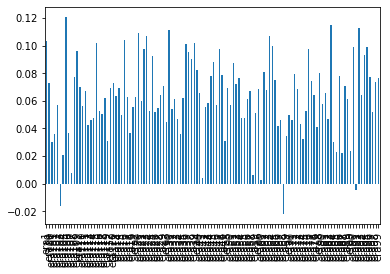

autocorrelation
0.027008032093386782
mean correlation
0.062492806274652604
sharpe
2.2237982027687666
smart sharpe
2.15597528886319
fitting on worst eras
iteration 1
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era72', 'era5', 'era78', 'era29', 'era81', 'era11', 'era13', 'era8', 'era14', 'era86', 'era93', 'era120', 'era28', 'era10', 'era108', 'era4', 'era52', 'era109', 'era40', 'era36', 'era90', 'era98', 'era71', 'era96', 'era6', 'era65', 'era53', 'era57', 'era61', 'era44', 'era48', 'era99', 'era25', 'era12', 'era94', 'era51', 'era63', 'era77', 'era83', 'era17', 'era115', 'era34', 'era105', 'era91', 'era111', 'era38', 'era64', 'era47', 'era39', 'era37', 'era22', 'era24', 'era117', 'era18', 'era20', 'era41', 'era23', 'era95', 'era97', 'era119']
performance over time


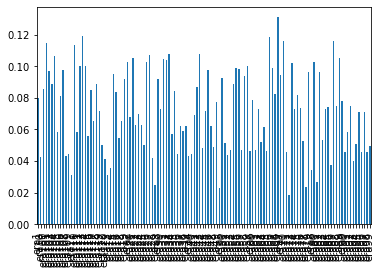

autocorrelation
0.03805156559752337
mean correlation
0.071721121424171
sharpe
2.757624087884622
smart sharpe
2.644370542139625
fitting on worst eras
iteration 2
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era103', 'era58', 'era104', 'era69', 'era60', 'era107', 'era85', 'era91', 'era27', 'era100', 'era112', 'era66', 'era101', 'era73', 'era74', 'era55', 'era54', 'era79', 'era41', 'era80', 'era67', 'era88', 'era9', 'era114', 'era46', 'era7', 'era113', 'era106', 'era84', 'era33', 'era87', 'era1', 'era116', 'era49', 'era21', 'era70', 'era26', 'era75', 'era62', 'era50', 'era59', 'era42', 'era40', 'era110', 'era89', 'era3', 'era82', 'era15', 'era31', 'era2', 'era32', 'era19', 'era102', 'era78', 'era118', 'era45', 'era12', 'era119', 'era111']
performance over time


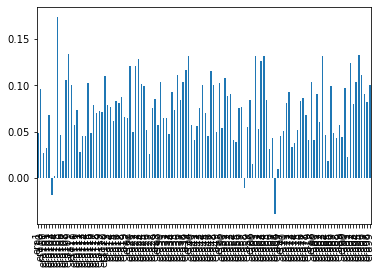

autocorrelation
0.10940728953583323
mean correlation
0.07201658746637782
sharpe
2.0333925764366443
smart sharpe
1.8159307269837328
fitting on worst eras
iteration 3
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era103', 'era35', 'era58', 'era117', 'era85', 'era100', 'era91', 'era5', 'era81', 'era98', 'era13', 'era56', 'era14', 'era79', 'era71', 'era93', 'era28', 'era25', 'era29', 'era34', 'era57', 'era97', 'era9', 'era6', 'era24', 'era67', 'era41', 'era77', 'era37', 'era18', 'era86', 'era53', 'era11', 'era43', 'era84', 'era90', 'era54', 'era65', 'era27', 'era74', 'era44', 'era76', 'era48', 'era60', 'era16', 'era104', 'era72', 'era114', 'era21', 'era116', 'era73', 'era107', 'era42', 'era75', 'era94', 'era49', 'era17', 'era3', 'era112']
performance over time


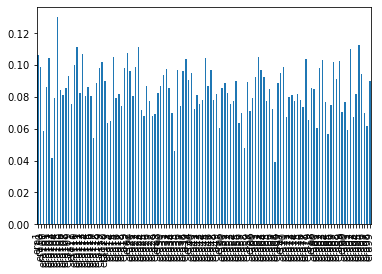

autocorrelation
0.03063723518430694
mean correlation
0.08377093909120194
sharpe
5.256573785175103
smart sharpe
5.077932076527158
fitting on worst eras
iteration 4
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era91', 'era69', 'era59', 'era103', 'era52', 'era80', 'era58', 'era106', 'era66', 'era101', 'era118', 'era33', 'era55', 'era46', 'era35', 'era119', 'era31', 'era85', 'era50', 'era40', 'era115', 'era110', 'era19', 'era89', 'era7', 'era51', 'era113', 'era120', 'era70', 'era32', 'era100', 'era30', 'era56', 'era26', 'era99', 'era4', 'era47', 'era8', 'era12', 'era117', 'era108', 'era41', 'era87', 'era88', 'era62', 'era96', 'era15', 'era102', 'era79', 'era9', 'era25', 'era45', 'era112', 'era82', 'era109', 'era98', 'era63', 'era28', 'era78']
performance over time


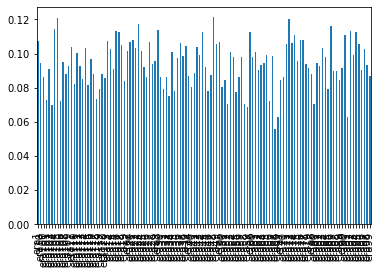

autocorrelation
0.12821546175763693
mean correlation
0.09402012422410122
sharpe
6.933721235215718
smart sharpe
6.0761724126974315
fitting on worst eras
iteration 5
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era81', 'era60', 'era67', 'era107', 'era68', 'era34', 'era42', 'era103', 'era75', 'era84', 'era64', 'era73', 'era91', 'era49', 'era29', 'era21', 'era18', 'era10', 'era2', 'era24', 'era65', 'era27', 'era13', 'era58', 'era83', 'era116', 'era111', 'era57', 'era74', 'era61', 'era71', 'era114', 'era106', 'era93', 'era40', 'era5', 'era97', 'era59', 'era36', 'era86', 'era22', 'era53', 'era14', 'era41', 'era48', 'era54', 'era69', 'era72', 'era46', 'era17', 'era44', 'era38', 'era85', 'era39', 'era118', 'era35', 'era77', 'era3', 'era104', 'era31']
performance over time


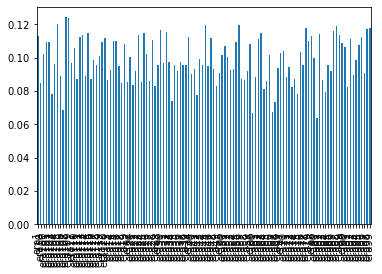

autocorrelation
-0.004592560521456508
mean correlation
0.09840961636555626
sharpe
7.306828264833436
smart sharpe
7.309533733636593
fitting on worst eras
iteration 6
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era66', 'era80', 'era43', 'era119', 'era100', 'era79', 'era19', 'era28', 'era33', 'era94', 'era91', 'era7', 'era112', 'era117', 'era11', 'era76', 'era34', 'era51', 'era107', 'era101', 'era113', 'era68', 'era70', 'era52', 'era55', 'era12', 'era87', 'era37', 'era90', 'era20', 'era99', 'era9', 'era95', 'era16', 'era88', 'era60', 'era67', 'era30', 'era63', 'era89', 'era62', 'era50', 'era25', 'era32', 'era8', 'era6', 'era102', 'era35', 'era54', 'era56', 'era29', 'era81', 'era110', 'era105', 'era4', 'era78', 'era115', 'era96', 'era84', 'era82']
performance over time


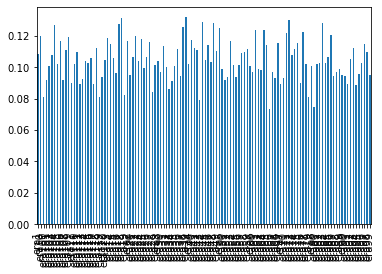

autocorrelation
-0.026722831891973546
mean correlation
0.10460653160688563
sharpe
8.077207744553204
smart sharpe
8.259536793372023
fitting on worst eras
iteration 7
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era103', 'era26', 'era58', 'era41', 'era69', 'era15', 'era116', 'era57', 'era65', 'era68', 'era59', 'era21', 'era85', 'era75', 'era106', 'era24', 'era42', 'era74', 'era104', 'era91', 'era49', 'era31', 'era18', 'era27', 'era73', 'era60', 'era40', 'era114', 'era33', 'era107', 'era98', 'era111', 'era117', 'era53', 'era14', 'era119', 'era47', 'era50', 'era120', 'era13', 'era3', 'era17', 'era46', 'era93', 'era9', 'era5', 'era1', 'era97', 'era112', 'era10', 'era100', 'era45', 'era67', 'era48', 'era66', 'era113', 'era118', 'era71', 'era81', 'era7']
performance over time


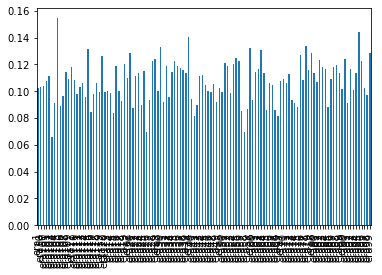

autocorrelation
0.012513368669436887
mean correlation
0.10739997973132473
sharpe
6.88479966057527
smart sharpe
6.771497049464768
fitting on worst eras
iteration 8
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era34', 'era109', 'era80', 'era108', 'era79', 'era23', 'era28', 'era77', 'era25', 'era86', 'era94', 'era101', 'era36', 'era2', 'era19', 'era102', 'era35', 'era61', 'era92', 'era29', 'era56', 'era43', 'era87', 'era51', 'era84', 'era85', 'era8', 'era72', 'era70', 'era64', 'era39', 'era22', 'era44', 'era116', 'era16', 'era11', 'era57', 'era41', 'era65', 'era89', 'era26', 'era110', 'era3', 'era103', 'era114', 'era83', 'era58', 'era63', 'era4', 'era90', 'era12', 'era32', 'era30', 'era52', 'era76', 'era37', 'era82', 'era21', 'era91', 'era96']
performance over time


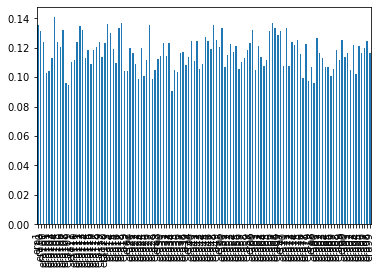

autocorrelation
0.18720561721099002
mean correlation
0.11674210603833303
sharpe
10.650928900042768
smart sharpe
8.790245056717024
fitting on worst eras
iteration 9
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era69', 'era60', 'era73', 'era107', 'era119', 'era106', 'era15', 'era62', 'era75', 'era40', 'era59', 'era117', 'era55', 'era88', 'era104', 'era103', 'era42', 'era67', 'era33', 'era66', 'era112', 'era31', 'era100', 'era58', 'era18', 'era46', 'era34', 'era6', 'era74', 'era9', 'era38', 'era54', 'era49', 'era41', 'era7', 'era113', 'era98', 'era47', 'era111', 'era91', 'era85', 'era27', 'era78', 'era101', 'era110', 'era17', 'era24', 'era118', 'era93', 'era99', 'era81', 'era5', 'era84', 'era50', 'era87', 'era79', 'era28', 'era97', 'era71']
performance over time


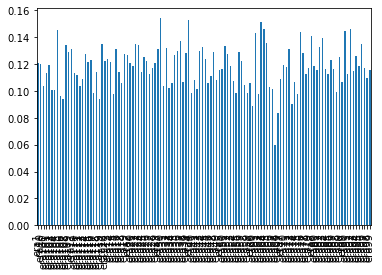

autocorrelation
0.0676114460919946
mean correlation
0.11808556028411922
sharpe
7.537161770215432
smart sharpe
7.01824471523567
fitting on worst eras
iteration 10
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era95', 'era25', 'era29', 'era53', 'era102', 'era115', 'era80', 'era20', 'era14', 'era56', 'era35', 'era51', 'era77', 'era116', 'era45', 'era94', 'era70', 'era120', 'era57', 'era105', 'era21', 'era108', 'era114', 'era48', 'era65', 'era16', 'era36', 'era11', 'era10', 'era23', 'era109', 'era3', 'era2', 'era43', 'era72', 'era1', 'era39', 'era86', 'era117', 'era32', 'era19', 'era22', 'era4', 'era89', 'era26', 'era31', 'era13', 'era69', 'era92', 'era63', 'era8', 'era59', 'era52', 'era46', 'era90', 'era9', 'era42', 'era96', 'era81', 'era61']
performance over time


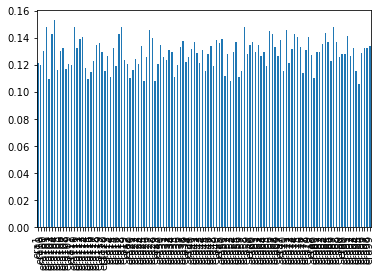

autocorrelation
0.03636408131697728
mean correlation
0.12835321358217291
sharpe
11.89520104381428
smart sharpe
11.425804213719486
fitting on worst eras
iteration 11
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era60', 'era103', 'era107', 'era119', 'era73', 'era58', 'era104', 'era66', 'era91', 'era33', 'era40', 'era112', 'era106', 'era88', 'era100', 'era67', 'era85', 'era15', 'era69', 'era55', 'era41', 'era34', 'era62', 'era7', 'era101', 'era54', 'era113', 'era12', 'era28', 'era75', 'era74', 'era27', 'era84', 'era87', 'era49', 'era111', 'era79', 'era44', 'era93', 'era110', 'era82', 'era78', 'era97', 'era98', 'era6', 'era37', 'era118', 'era17', 'era21', 'era80', 'era50', 'era18', 'era24', 'era99', 'era70', 'era47', 'era14', 'era71', 'era76']
performance over time


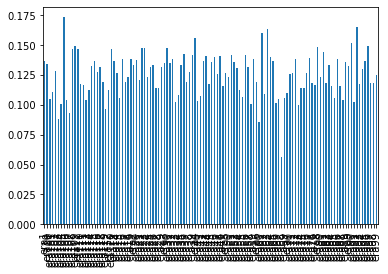

autocorrelation
0.01589690851808934
mean correlation
0.1257048161719361
sharpe
6.967479343492413
smart sharpe
6.829856535374996
fitting on worst eras
iteration 12
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era53', 'era25', 'era116', 'era102', 'era35', 'era65', 'era95', 'era29', 'era81', 'era57', 'era83', 'era64', 'era94', 'era5', 'era68', 'era107', 'era45', 'era56', 'era117', 'era9', 'era51', 'era10', 'era38', 'era39', 'era30', 'era34', 'era3', 'era77', 'era4', 'era32', 'era60', 'era40', 'era2', 'era11', 'era114', 'era12', 'era46', 'era36', 'era52', 'era31', 'era115', 'era89', 'era72', 'era54', 'era48', 'era33', 'era86', 'era16', 'era42', 'era20', 'era111', 'era59', 'era106', 'era120', 'era26', 'era119', 'era85', 'era7', 'era103', 'era43']
performance over time


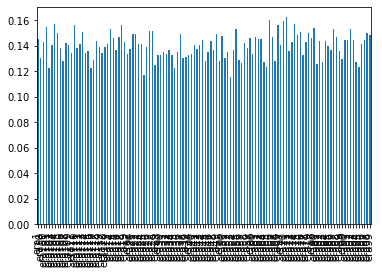

autocorrelation
0.0856282428836932
mean correlation
0.14013873190203432
sharpe
14.372017281304801
smart sharpe
13.144190237777744
fitting on worst eras
iteration 13
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era91', 'era19', 'era66', 'era100', 'era73', 'era41', 'era112', 'era58', 'era15', 'era67', 'era55', 'era28', 'era13', 'era60', 'era88', 'era75', 'era79', 'era78', 'era62', 'era104', 'era108', 'era118', 'era82', 'era84', 'era74', 'era101', 'era113', 'era37', 'era44', 'era87', 'era21', 'era69', 'era23', 'era80', 'era97', 'era22', 'era96', 'era93', 'era14', 'era98', 'era6', 'era35', 'era27', 'era107', 'era1', 'era49', 'era8', 'era109', 'era90', 'era24', 'era99', 'era103', 'era17', 'era76', 'era47', 'era116', 'era29', 'era50', 'era18']
performance over time


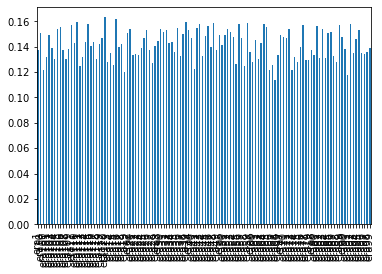

autocorrelation
-0.05502951024117328
mean correlation
0.14184368757530494
sharpe
12.386588945408183
smart sharpe
13.02741032357609
fitting on worst eras
iteration 14
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era63', 'era65', 'era53', 'era81', 'era117', 'era57', 'era61', 'era25', 'era64', 'era34', 'era102', 'era9', 'era95', 'era105', 'era94', 'era45', 'era54', 'era110', 'era31', 'era51', 'era56', 'era83', 'era36', 'era32', 'era3', 'era70', 'era10', 'era40', 'era111', 'era46', 'era39', 'era5', 'era114', 'era7', 'era119', 'era33', 'era4', 'era11', 'era12', 'era77', 'era38', 'era92', 'era52', 'era20', 'era71', 'era59', 'era89', 'era16', 'era42', 'era30', 'era85', 'era48', 'era26', 'era2', 'era82', 'era91', 'era112', 'era72', 'era43', 'era106']
performance over time


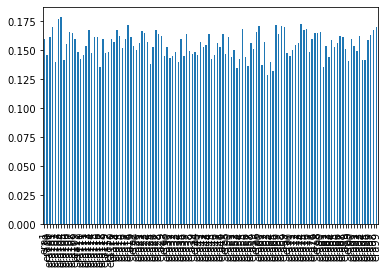

autocorrelation
0.13173988007483386
mean correlation
0.15498839603952824
sharpe
14.66150756934683
smart sharpe
12.802619845909046
fitting on worst eras
iteration 15
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era60', 'era58', 'era66', 'era19', 'era69', 'era73', 'era41', 'era67', 'era15', 'era104', 'era21', 'era86', 'era107', 'era62', 'era28', 'era84', 'era88', 'era13', 'era100', 'era55', 'era87', 'era103', 'era75', 'era78', 'era27', 'era79', 'era74', 'era101', 'era29', 'era37', 'era113', 'era17', 'era35', 'era93', 'era80', 'era44', 'era116', 'era96', 'era14', 'era118', 'era22', 'era18', 'era97', 'era3', 'era91', 'era119', 'era47', 'era33', 'era34', 'era24', 'era90', 'era98', 'era117', 'era49', 'era50', 'era115', 'era6', 'era120', 'era108']
performance over time


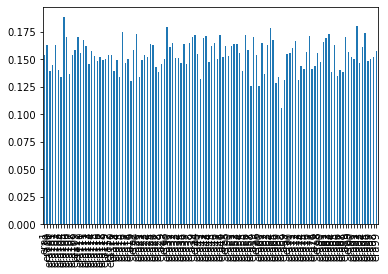

autocorrelation
0.049363313057913055
mean correlation
0.15397187916644756
sharpe
11.14967664215853
smart sharpe
10.572279571782628
fitting on worst eras
iteration 16
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era65', 'era1', 'era63', 'era9', 'era81', 'era53', 'era57', 'era54', 'era70', 'era23', 'era25', 'era51', 'era102', 'era61', 'era12', 'era76', 'era2', 'era7', 'era111', 'era109', 'era31', 'era56', 'era10', 'era32', 'era39', 'era8', 'era40', 'era45', 'era99', 'era36', 'era4', 'era114', 'era16', 'era59', 'era46', 'era95', 'era11', 'era64', 'era110', 'era5', 'era52', 'era94', 'era21', 'era89', 'era58', 'era83', 'era82', 'era42', 'era77', 'era116', 'era112', 'era85', 'era72', 'era62', 'era26', 'era35', 'era71', 'era20', 'era84', 'era29']
performance over time


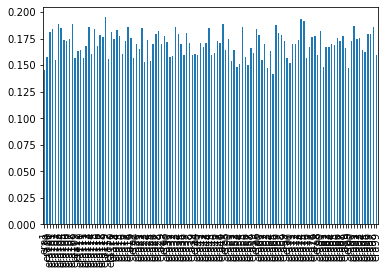

autocorrelation
0.012215745360557919
mean correlation
0.16990338928742962
sharpe
14.376437004643
smart sharpe
14.1440196162019
fitting on worst eras
iteration 17
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era60', 'era66', 'era69', 'era41', 'era67', 'era73', 'era19', 'era15', 'era88', 'era107', 'era103', 'era104', 'era13', 'era100', 'era28', 'era86', 'era87', 'era43', 'era55', 'era75', 'era27', 'era93', 'era74', 'era91', 'era17', 'era79', 'era48', 'era119', 'era118', 'era78', 'era44', 'era37', 'era3', 'era22', 'era101', 'era34', 'era38', 'era106', 'era113', 'era117', 'era33', 'era98', 'era96', 'era80', 'era54', 'era18', 'era6', 'era90', 'era24', 'era7', 'era47', 'era21', 'era97', 'era57', 'era9', 'era58', 'era108', 'era12', 'era14']
performance over time


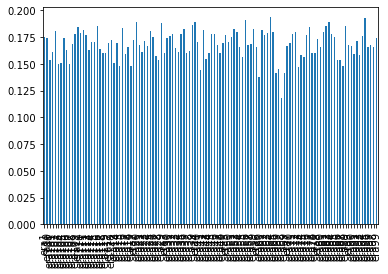

autocorrelation
0.18892935699201552
mean correlation
0.16853497062849565
sharpe
12.810880496716706
smart sharpe
10.554152896392623
fitting on worst eras
iteration 18
predicting on train


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-3-d09c93fc60e4>:22: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era65', 'era105', 'era30', 'era50', 'era81', 'era92', 'era53', 'era1', 'era63', 'era120', 'era51', 'era2', 'era70', 'era23', 'era25', 'era11', 'era102', 'era10', 'era8', 'era16', 'era46', 'era61', 'era45', 'era56', 'era111', 'era114', 'era32', 'era31', 'era115', 'era35', 'era39', 'era116', 'era40', 'era99', 'era77', 'era59', 'era62', 'era76', 'era52', 'era49', 'era36', 'era42', 'era109', 'era95', 'era26', 'era5', 'era94', 'era4', 'era43', 'era64', 'era29', 'era69', 'era110', 'era82', 'era89', 'era85', 'era84', 'era72', 'era112', 'era107']
performance over time


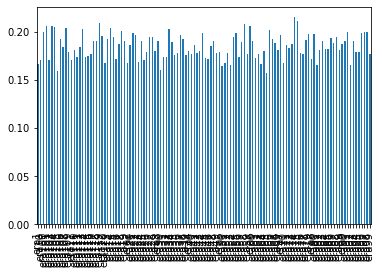

autocorrelation
0.0005516355320913831
mean correlation
0.18516329117673214
sharpe
14.569425934574689
smart sharpe
14.500658402770187
fitting on worst eras


In [4]:
boost_model = era_boost_train(df[features], df["target"], era_col=df["era"], proportion=0.5, trees_per_step=10, num_iters=20)

In [6]:
tournament_df = pd.read_csv('./numerai_tournament_data.csv')
val_df = tournament_df[tournament_df['target'].notnull()]


/home/arsenii/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-5-028230d9b9d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['pred'] = xgb_preds


<AxesSubplot:title={'center':'XGBoost'}, xlabel='Eras', ylabel='SpearmanK'>

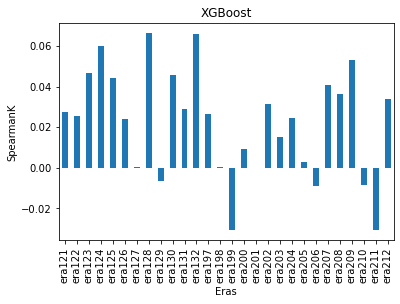

In [5]:

xgb_preds = boost_model.predict(val_df[features])
val_era_scores = pd.Series(index=val_df["era"].unique(), dtype='float64')   
val_df['pred'] = xgb_preds

for era in val_df["era"].unique():
    val_era_df = val_df[val_df["era"] == era].copy()
    val_era_scores[era] = spearmanr(val_era_df["target"], val_era_df["pred"])

val_era_scores.plot(kind="bar",xlabel='Eras', ylabel='SpearmanK', title='XGBoost')

In [7]:
import pickle
pickle.dump(boost_model, open('xgb_fitted_on_worst_eras', 'wb'))

In [2]:
from lightgbm import LGBMRegressor

def era_boost_train(X, y,era_col, proportion=0.5, trees_per_step=10, num_iters=200):
    model = LGBMRegressor(
            device='gpu',
            learning_rate=0.01,
            n_estimators=trees_per_step,
            max_depth=5,
#             boosting_type: 'gbdt',
#             num_leaves: 31,,
#             feature_fraction': hp.uniform('feature_fraction', 0, 1),
#             subsample': hp.uniform('subsample', 0.5, 1.),
#             lambda_l1': hp.loguniform('lambda_l1', -3, 2),
#             lambda_l2': hp.loguniform('lambda_l2', -3, 2),
    )
    features = X.columns
    model.fit(X, y)
    new_df = X.copy()
    new_df["target"] = y
    new_df["era"] = era_col
    for i in range(num_iters-1):
        print(f"iteration {i}")
        # score each era
        print("predicting on train")
        preds = model.predict(X)
        new_df["pred"] = preds
        era_scores = pd.Series(index=new_df["era"].unique())
        print("getting per era scores")
        for era in new_df["era"].unique():
            era_df = new_df[new_df["era"] == era]
            era_scores[era] = spearmanr(era_df["pred"], era_df["target"])
        era_scores.sort_values(inplace=True)
        worst_eras = era_scores[era_scores <= era_scores.quantile(proportion)].index
        print(list(worst_eras))
        worst_df = new_df[new_df["era"].isin(worst_eras)]
        era_scores.sort_index(inplace=True)
        era_scores.plot(kind="bar")
        print("performance over time")
        plt.show()
        print("autocorrelation")
        print(ar1(era_scores))
        print("mean correlation")
        print(np.mean(era_scores))
        print("sharpe")
        print(np.mean(era_scores)/np.std(era_scores))
        print("smart sharpe")
        print(smart_sharpe(era_scores))
        model.n_estimators += trees_per_step
        booster = model.booster_
        print("fitting on worst eras")
        model.fit(worst_df[features], worst_df["target"], init_model=booster)
    return model

iteration 0
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era103', 'era91', 'era68', 'era58', 'era101', 'era107', 'era69', 'era60', 'era116', 'era119', 'era9', 'era54', 'era15', 'era49', 'era84', 'era75', 'era35', 'era66', 'era114', 'era17', 'era85', 'era87', 'era70', 'era78', 'era24', 'era104', 'era46', 'era80', 'era93', 'era110', 'era37', 'era112', 'era27', 'era44', 'era41', 'era100', 'era88', 'era34', 'era56', 'era33', 'era99', 'era117', 'era106', 'era21', 'era67', 'era57', 'era43', 'era59', 'era111', 'era113', 'era6', 'era89', 'era32', 'era26', 'era50', 'era19', 'era11', 'era102', 'era31', 'era52']
performance over time


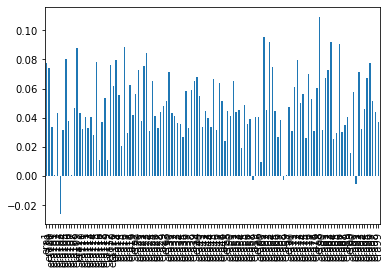

autocorrelation
-0.01760827760979943
mean correlation
0.04670400967004524
sharpe
1.9634951718809326
smart sharpe
1.9897427308896942
fitting on worst eras
iteration 1
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era90', 'era81', 'era42', 'era118', 'era65', 'era40', 'era36', 'era74', 'era48', 'era9', 'era7', 'era5', 'era4', 'era94', 'era98', 'era86', 'era103', 'era29', 'era109', 'era120', 'era28', 'era58', 'era73', 'era91', 'era72', 'era97', 'era12', 'era79', 'era115', 'era75', 'era47', 'era64', 'era71', 'era55', 'era8', 'era45', 'era108', 'era61', 'era3', 'era62', 'era92', 'era77', 'era34', 'era2', 'era107', 'era30', 'era14', 'era63', 'era116', 'era66', 'era84', 'era95', 'era19', 'era119', 'era53', 'era18', 'era80', 'era25', 'era6', 'era38']
performance over time


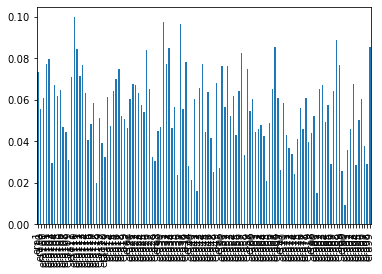

autocorrelation
0.12911636857574063
mean correlation
0.05417258743480516
sharpe
2.7987450248694086
smart sharpe
2.4503754644258735
fitting on worst eras
iteration 2
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era69', 'era103', 'era104', 'era112', 'era58', 'era91', 'era41', 'era50', 'era101', 'era85', 'era42', 'era102', 'era117', 'era106', 'era70', 'era57', 'era87', 'era17', 'era1', 'era27', 'era100', 'era24', 'era116', 'era15', 'era31', 'era60', 'era113', 'era40', 'era56', 'era35', 'era9', 'era46', 'era107', 'era21', 'era89', 'era67', 'era54', 'era71', 'era59', 'era114', 'era26', 'era33', 'era3', 'era111', 'era65', 'era51', 'era110', 'era73', 'era93', 'era82', 'era84', 'era18', 'era10', 'era44', 'era62', 'era88', 'era66', 'era79', 'era20']
performance over time


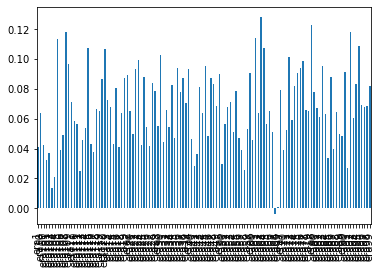

autocorrelation
0.08202907148853177
mean correlation
0.06665658297532376
sharpe
2.5495744937153617
smart sharpe
2.3401551553822464
fitting on worst eras
iteration 3
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era34', 'era80', 'era78', 'era118', 'era28', 'era119', 'era105', 'era49', 'era94', 'era35', 'era98', 'era13', 'era12', 'era68', 'era43', 'era75', 'era85', 'era100', 'era37', 'era112', 'era81', 'era74', 'era6', 'era109', 'era4', 'era41', 'era2', 'era91', 'era14', 'era86', 'era22', 'era99', 'era83', 'era19', 'era32', 'era29', 'era7', 'era117', 'era36', 'era90', 'era71', 'era24', 'era25', 'era102', 'era76', 'era9', 'era16', 'era97', 'era3', 'era93', 'era115', 'era113', 'era56', 'era52', 'era103', 'era44', 'era21', 'era17', 'era61', 'era45']
performance over time


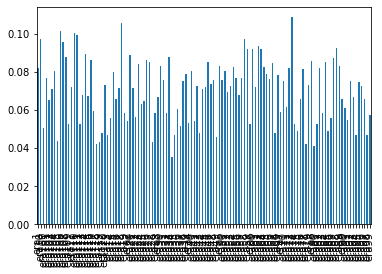

autocorrelation
0.023215691658639733
mean correlation
0.0703192585730962
sharpe
4.290570402087972
smart sharpe
4.175396409504355
fitting on worst eras
iteration 4
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era69', 'era68', 'era91', 'era58', 'era103', 'era50', 'era104', 'era119', 'era107', 'era65', 'era101', 'era60', 'era73', 'era54', 'era110', 'era106', 'era40', 'era116', 'era53', 'era42', 'era59', 'era70', 'era57', 'era15', 'era13', 'era11', 'era27', 'era89', 'era18', 'era87', 'era33', 'era85', 'era113', 'era111', 'era41', 'era112', 'era114', 'era62', 'era82', 'era46', 'era47', 'era84', 'era39', 'era32', 'era80', 'era67', 'era38', 'era79', 'era31', 'era77', 'era51', 'era96', 'era93', 'era9', 'era26', 'era120', 'era102', 'era17', 'era1', 'era30']
performance over time


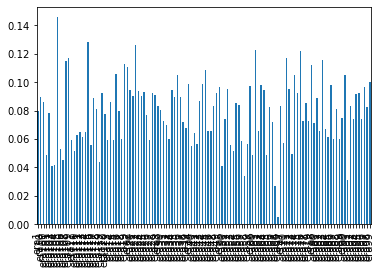

autocorrelation
-0.050048733422982
mean correlation
0.07877294774184071
sharpe
3.341494585329429
smart sharpe
3.4970043509330364
fitting on worst eras
iteration 5
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era34', 'era66', 'era118', 'era56', 'era28', 'era12', 'era3', 'era63', 'era49', 'era43', 'era29', 'era98', 'era75', 'era36', 'era78', 'era7', 'era92', 'era100', 'era21', 'era86', 'era19', 'era119', 'era117', 'era91', 'era68', 'era99', 'era95', 'era14', 'era4', 'era90', 'era48', 'era81', 'era55', 'era57', 'era84', 'era35', 'era105', 'era94', 'era65', 'era72', 'era69', 'era44', 'era13', 'era74', 'era108', 'era114', 'era22', 'era23', 'era8', 'era20', 'era89', 'era16', 'era31', 'era42', 'era40', 'era115', 'era37', 'era101', 'era41', 'era6']
performance over time


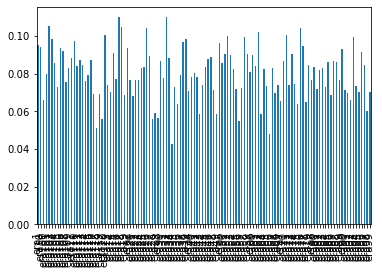

autocorrelation
0.10819493073303743
mean correlation
0.08041288212825129
sharpe
5.876757886062024
smart sharpe
5.25465389213448
fitting on worst eras
iteration 6
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era107', 'era69', 'era58', 'era103', 'era50', 'era68', 'era104', 'era111', 'era106', 'era110', 'era15', 'era113', 'era60', 'era116', 'era85', 'era9', 'era88', 'era53', 'era33', 'era54', 'era24', 'era79', 'era91', 'era62', 'era46', 'era73', 'era27', 'era82', 'era67', 'era119', 'era39', 'era80', 'era59', 'era112', 'era87', 'era65', 'era97', 'era70', 'era117', 'era5', 'era21', 'era26', 'era18', 'era47', 'era93', 'era40', 'era41', 'era10', 'era56', 'era52', 'era3', 'era57', 'era32', 'era25', 'era38', 'era29', 'era101', 'era7', 'era42', 'era51']
performance over time


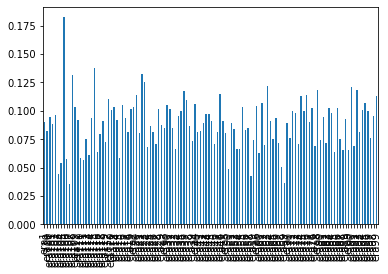

autocorrelation
-0.09664855381632977
mean correlation
0.08832637263662296
sharpe
3.9957777600056597
smart sharpe
4.3806318042221495
fitting on worst eras
iteration 7
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era34', 'era12', 'era83', 'era19', 'era66', 'era14', 'era49', 'era118', 'era71', 'era100', 'era43', 'era75', 'era98', 'era114', 'era44', 'era77', 'era35', 'era84', 'era74', 'era109', 'era81', 'era45', 'era94', 'era3', 'era61', 'era28', 'era90', 'era64', 'era96', 'era8', 'era89', 'era2', 'era11', 'era31', 'era4', 'era55', 'era63', 'era16', 'era99', 'era86', 'era36', 'era78', 'era67', 'era27', 'era1', 'era46', 'era30', 'era107', 'era80', 'era111', 'era7', 'era15', 'era37', 'era79', 'era21', 'era9', 'era33', 'era24', 'era72', 'era117']
performance over time


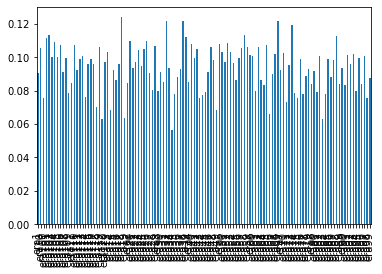

autocorrelation
-0.06583931320924717
mean correlation
0.09369793334028456
sharpe
6.754766253909926
smart sharpe
7.181068524187998
fitting on worst eras
iteration 8
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era68', 'era103', 'era69', 'era58', 'era91', 'era50', 'era60', 'era113', 'era106', 'era116', 'era85', 'era110', 'era104', 'era59', 'era54', 'era17', 'era107', 'era70', 'era119', 'era65', 'era102', 'era112', 'era88', 'era73', 'era101', 'era62', 'era53', 'era18', 'era56', 'era39', 'era41', 'era42', 'era26', 'era93', 'era40', 'era82', 'era87', 'era47', 'era57', 'era52', 'era114', 'era32', 'era33', 'era25', 'era13', 'era89', 'era97', 'era9', 'era95', 'era46', 'era10', 'era75', 'era43', 'era51', 'era6', 'era38', 'era15', 'era111', 'era5', 'era20']
performance over time


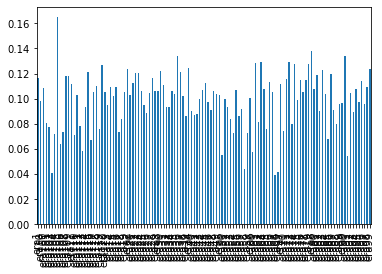

autocorrelation
0.0207330734990033
mean correlation
0.09888961491796079
sharpe
4.51567378220703
smart sharpe
4.405294520252281
fitting on worst eras
iteration 9
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era34', 'era19', 'era12', 'era84', 'era22', 'era66', 'era3', 'era44', 'era71', 'era28', 'era76', 'era115', 'era100', 'era49', 'era105', 'era48', 'era108', 'era77', 'era83', 'era61', 'era55', 'era35', 'era118', 'era31', 'era67', 'era14', 'era109', 'era4', 'era16', 'era68', 'era80', 'era99', 'era60', 'era112', 'era92', 'era98', 'era94', 'era86', 'era43', 'era21', 'era45', 'era81', 'era2', 'era79', 'era120', 'era103', 'era96', 'era23', 'era74', 'era17', 'era11', 'era85', 'era29', 'era91', 'era116', 'era63', 'era41', 'era64', 'era7', 'era42']
performance over time


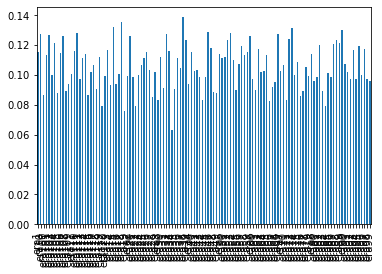

autocorrelation
-0.016229950684934102
mean correlation
0.10558064153147605
sharpe
7.10244574701481
smart sharpe
7.187555877405611
fitting on worst eras
iteration 10
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era69', 'era58', 'era106', 'era50', 'era110', 'era107', 'era119', 'era68', 'era65', 'era59', 'era103', 'era101', 'era54', 'era113', 'era62', 'era91', 'era73', 'era70', 'era56', 'era27', 'era9', 'era24', 'era1', 'era117', 'era39', 'era116', 'era104', 'era40', 'era60', 'era5', 'era87', 'era32', 'era37', 'era93', 'era57', 'era25', 'era47', 'era34', 'era13', 'era102', 'era53', 'era89', 'era18', 'era17', 'era46', 'era26', 'era85', 'era111', 'era52', 'era33', 'era82', 'era78', 'era112', 'era51', 'era88', 'era15', 'era21', 'era114', 'era10', 'era95']
performance over time


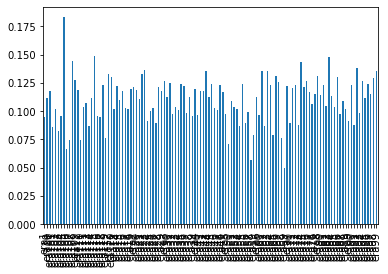

autocorrelation
-0.08640286908162584
mean correlation
0.11002356339694035
sharpe
5.460882891613441
smart sharpe
5.925827201417213
fitting on worst eras
iteration 11
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era19', 'era12', 'era34', 'era66', 'era84', 'era118', 'era28', 'era61', 'era44', 'era49', 'era71', 'era80', 'era90', 'era105', 'era100', 'era16', 'era79', 'era14', 'era77', 'era22', 'era36', 'era48', 'era109', 'era35', 'era75', 'era4', 'era115', 'era63', 'era76', 'era2', 'era45', 'era86', 'era30', 'era31', 'era99', 'era11', 'era3', 'era41', 'era83', 'era20', 'era96', 'era94', 'era97', 'era67', 'era7', 'era23', 'era108', 'era98', 'era72', 'era42', 'era6', 'era55', 'era8', 'era56', 'era29', 'era81', 'era43', 'era51', 'era27', 'era21']
performance over time


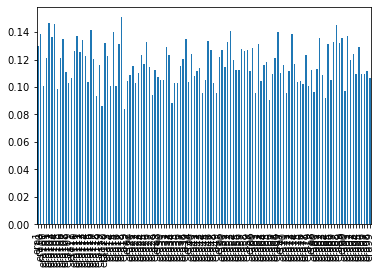

autocorrelation
0.003101758776493472
mean correlation
0.11666041715080153
sharpe
7.849771049952556
smart sharpe
7.792987735729278
fitting on worst eras
iteration 12
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era69', 'era58', 'era68', 'era107', 'era106', 'era50', 'era103', 'era119', 'era91', 'era65', 'era110', 'era73', 'era59', 'era101', 'era60', 'era54', 'era104', 'era113', 'era62', 'era9', 'era70', 'era85', 'era40', 'era116', 'era102', 'era87', 'era32', 'era39', 'era24', 'era38', 'era111', 'era57', 'era17', 'era117', 'era25', 'era46', 'era93', 'era33', 'era112', 'era53', 'era89', 'era1', 'era18', 'era15', 'era26', 'era52', 'era13', 'era37', 'era5', 'era47', 'era64', 'era114', 'era82', 'era88', 'era27', 'era84', 'era10', 'era42', 'era56', 'era6']
performance over time


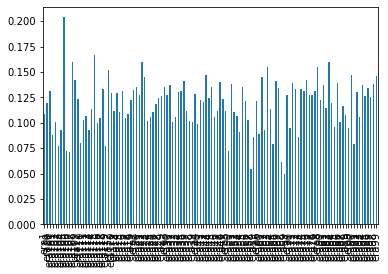

autocorrelation
-0.042725766841158495
mean correlation
0.11789370664989904
sharpe
4.802144798943293
smart sharpe
4.98919087947749
fitting on worst eras
iteration 13
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era19', 'era34', 'era66', 'era28', 'era74', 'era12', 'era35', 'era61', 'era49', 'era80', 'era2', 'era44', 'era100', 'era75', 'era118', 'era11', 'era21', 'era3', 'era4', 'era71', 'era14', 'era16', 'era90', 'era79', 'era78', 'era41', 'era92', 'era36', 'era77', 'era31', 'era55', 'era30', 'era48', 'era29', 'era99', 'era86', 'era95', 'era96', 'era83', 'era68', 'era63', 'era7', 'era23', 'era45', 'era67', 'era105', 'era109', 'era98', 'era51', 'era37', 'era22', 'era97', 'era8', 'era20', 'era84', 'era94', 'era72', 'era119', 'era115', 'era76']
performance over time


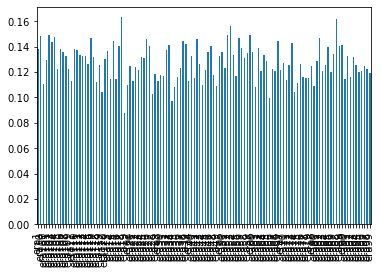

autocorrelation
0.08420784868158768
mean correlation
0.1276675818597842
sharpe
9.204330558938945
smart sharpe
8.429938418021337
fitting on worst eras
iteration 14
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era69', 'era58', 'era107', 'era50', 'era91', 'era106', 'era103', 'era65', 'era68', 'era73', 'era104', 'era70', 'era60', 'era110', 'era116', 'era59', 'era113', 'era101', 'era102', 'era54', 'era9', 'era62', 'era40', 'era111', 'era39', 'era32', 'era33', 'era87', 'era24', 'era18', 'era46', 'era117', 'era93', 'era57', 'era17', 'era26', 'era112', 'era81', 'era85', 'era15', 'era25', 'era5', 'era56', 'era38', 'era89', 'era13', 'era21', 'era53', 'era27', 'era47', 'era82', 'era1', 'era52', 'era119', 'era42', 'era41', 'era114', 'era10', 'era64', 'era11']
performance over time


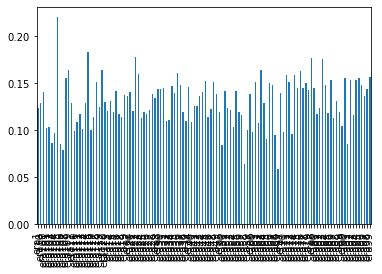

autocorrelation
-0.015603724282811642
mean correlation
0.12996250834481612
sharpe
5.115491554983158
smart sharpe
5.173576949276208
fitting on worst eras
iteration 15
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era66', 'era19', 'era34', 'era28', 'era12', 'era43', 'era61', 'era100', 'era35', 'era108', 'era74', 'era3', 'era44', 'era49', 'era55', 'era118', 'era14', 'era29', 'era98', 'era16', 'era75', 'era71', 'era2', 'era31', 'era79', 'era80', 'era90', 'era7', 'era120', 'era4', 'era99', 'era67', 'era63', 'era51', 'era97', 'era77', 'era78', 'era70', 'era86', 'era37', 'era36', 'era30', 'era84', 'era105', 'era23', 'era20', 'era6', 'era48', 'era92', 'era96', 'era45', 'era94', 'era83', 'era21', 'era115', 'era8', 'era72', 'era95', 'era109', 'era40']
performance over time


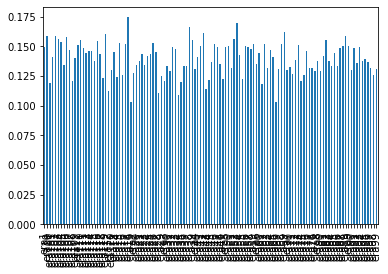

autocorrelation
0.04931358575299975
mean correlation
0.1397014875681262
sharpe
10.09868413731654
smart sharpe
9.576187104452014
fitting on worst eras
iteration 16
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era69', 'era58', 'era107', 'era68', 'era103', 'era50', 'era91', 'era106', 'era65', 'era60', 'era104', 'era110', 'era73', 'era113', 'era111', 'era116', 'era9', 'era59', 'era102', 'era101', 'era62', 'era54', 'era85', 'era18', 'era24', 'era32', 'era39', 'era87', 'era33', 'era88', 'era119', 'era117', 'era57', 'era27', 'era15', 'era26', 'era5', 'era93', 'era112', 'era13', 'era56', 'era41', 'era17', 'era46', 'era81', 'era89', 'era82', 'era52', 'era25', 'era11', 'era53', 'era70', 'era47', 'era38', 'era42', 'era1', 'era114', 'era10', 'era40', 'era29']
performance over time


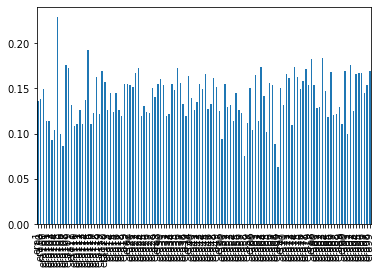

autocorrelation
0.005488393025116752
mean correlation
0.13977560753691434
sharpe
5.333170473591083
smart sharpe
5.282075269764477
fitting on worst eras
iteration 17
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era66', 'era34', 'era19', 'era12', 'era61', 'era76', 'era28', 'era43', 'era3', 'era16', 'era55', 'era64', 'era49', 'era22', 'era100', 'era14', 'era98', 'era35', 'era84', 'era44', 'era80', 'era31', 'era118', 'era108', 'era37', 'era67', 'era71', 'era74', 'era90', 'era23', 'era97', 'era105', 'era4', 'era77', 'era20', 'era21', 'era79', 'era51', 'era63', 'era99', 'era2', 'era8', 'era75', 'era72', 'era48', 'era7', 'era36', 'era83', 'era30', 'era115', 'era65', 'era109', 'era6', 'era45', 'era117', 'era24', 'era25', 'era86', 'era60', 'era120']
performance over time


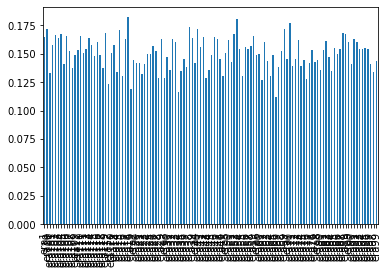

autocorrelation
-0.014521473284594575
mean correlation
0.15034419363542764
sharpe
10.775089020067636
smart sharpe
10.885746183044889
fitting on worst eras
iteration 18
predicting on train


<ipython-input-2-23ec3f67369a>:37: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  era_scores = pd.Series(index=new_df["era"].unique())


getting per era scores
['era69', 'era68', 'era58', 'era107', 'era103', 'era106', 'era91', 'era50', 'era73', 'era104', 'era110', 'era116', 'era62', 'era102', 'era113', 'era54', 'era9', 'era32', 'era111', 'era87', 'era101', 'era39', 'era119', 'era33', 'era56', 'era27', 'era57', 'era59', 'era82', 'era85', 'era93', 'era41', 'era17', 'era18', 'era1', 'era60', 'era42', 'era29', 'era88', 'era112', 'era5', 'era26', 'era47', 'era89', 'era15', 'era70', 'era13', 'era81', 'era114', 'era11', 'era46', 'era52', 'era78', 'era10', 'era95', 'era53', 'era38', 'era65', 'era40', 'era55']
performance over time


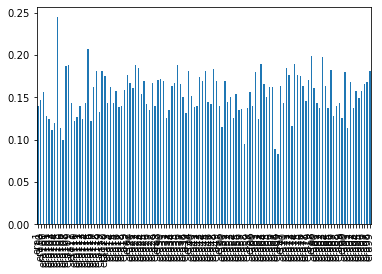

autocorrelation
0.012301664017695918
mean correlation
0.15341541108083562
sharpe
5.993963407213651
smart sharpe
5.89655920040023
fitting on worst eras


In [3]:
lgbModel = era_boost_train(df[features], df["target"], era_col=df["era"], proportion=0.5, trees_per_step=10, num_iters=20)

<ipython-input-11-6893b6caa577>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['pred'] = lgb_preds


<AxesSubplot:title={'center':'LGBoost'}, xlabel='Eras', ylabel='SpearmanK'>

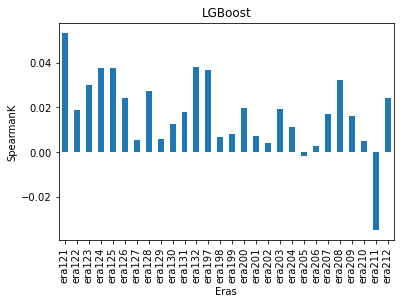

In [11]:
tournament_df = pd.read_csv('./Latest_dataset/numerai_tournament_data.csv')
val_df = tournament_df[tournament_df['target'].notnull()]

lgb_preds = lgbModel.predict(val_df[features])
val_era_scores = pd.Series(index=val_df["era"].unique(), dtype='float64')   
val_df['pred'] = lgb_preds

for era in val_df["era"].unique():
    val_era_df = val_df[val_df["era"] == era].copy()
    val_era_scores[era] = spearmanr(val_era_df["target"], val_era_df["pred"])

val_era_scores.plot(kind="bar",xlabel='Eras', ylabel='SpearmanK', title='LGBoost')

In [ ]:
tournament_df = pd.read_csv('./Latest_dataset/numerai_tournament_data.csv')
tournament_data = tournament_df.set_index("id")

predictions = lgbModel.predict(tournament_data[features])

tournament_data['prediction'] = predictions
tournament_data['prediction'].to_csv("predictions_29_apr.csv", header=True)

In [12]:
import pickle
pickle.dump(lgbModel, open('lgbm_fitted_on_worst_eras', 'wb'))